# wGAN 논문 구조 구현

### 기존 GAN의 손실함수를 재정의 함으로써 학습의 안정성을 높였다.

## 패키지 import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid as make_grid
import matplotlib.pyplot as plt

In [2]:
input = torch.rand(5, 1, 1,1)
input.reshape(-1)

tensor([0.4539, 0.0655, 0.4696, 0.3697, 0.4102])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LEARNING_RATE = 2e-4
BATCH_SIZE  = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

In [ ]:
transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])  
])

## 생성자, 구분자(판별자) 정의

In [ ]:
class Critic(nn.Module): #구분자 정의
  def __init__(self, channels_img, features_d): #이미지 채널, 곱해나갈 채널을 parameter로 받는다.
    super(Critic, self).__init__()
    self.disc = nn.Sequential(
        #input : N x channels_img x 64 x 64
        nn.Conv2d(channels_img, features_d, kernel_size = 4, stride = 2, padding = 1), #4,2,1로 맞춰주면 이미지의 크기가 2씩 줄어든다.
        nn.LeakyReLU(0.2),
        self._block(features_d, features_d * 2, 4, 2, 1),
        self._block(features_d * 2, features_d * 4, 4, 2, 1),
        self._block(features_d * 4, features_d * 8, 4, 2, 1),
        nn.Conv2d(features_d * 8, 1, kernel_size = 4, stride = 2, padding = 0)
    ) #판별자와 달리 sigmoid가 없다는 것이 큰 차이점이다.
  def _block(self, in_channels, out_channels, kernel_size, stride, padding): #중첩할 블럭들을 미리 정의해준다.
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
  def forward(self, x):
    return self.disc(x) #output 값은 (b, 1, 1, 1)

In [ ]:
input = torch.rand(64, 1, 64, 64)
critic = Critic(1, 64)
output = critic(input)
output.size()

torch.Size([64, 1, 1, 1])

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim, channels_img, features_g):
    super(Generator, self).__init__()
    #input : N x z_dim x 1 x 1
    self.gen = nn.Sequential(
        self._block(z_dim, features_g * 16, 4, 1, 0),
        self._block(features_g * 16, features_g * 8, 4, 2, 1),
        self._block(features_g * 8, features_g * 4, 4, 2, 1),
        self._block(features_g * 4, features_g * 2, 4, 2, 1),
        nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size = 4, stride = 2, padding = 1),
        nn.Tanh()
    )
  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(  #이미지의 크기를 늘리기 위해 convtranspose2d 를 사용하였다.
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

  def forward(self, x):
    return self.gen(x)

## 가중치 초기화

In [ ]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

## FashionMNIST 데이터셋



In [ ]:
dataset = datasets.FashionMNIST(root = '/content/MyDrive', train = True, transform = transforms, download  = True)
trainloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device) #gpu로 연결해준다.
critic = Critic(CHANNELS_IMG, FEATURES_CRITIC).to(device)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/MyDrive/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/MyDrive/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/MyDrive/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/MyDrive/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/MyDrive/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/MyDrive/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/MyDrive/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MyDrive/FashionMNIST/raw



In [ ]:
data, label = iter(trainloader).next()
print(data.shape) #64개의 batchsize와 64x64크기의 이미지임을 알 수 있다.

torch.Size([64, 1, 64, 64])


In [ ]:
initialize_weights(gen)
initialize_weights(critic)

In [ ]:
opt_gen = optim.RMSprop(gen.parameters(), lr = LEARNING_RATE) #최적화는 Adam 대신 RMSprop을 사용해준다.
opt_critic = optim.RMSprop(critic.parameters(), lr = LEARNING_RATE)

In [ ]:
fixed_noise = torch.rand(32, Z_DIM, 1, 1).to(device) 
step = 0

In [ ]:
gen.train()
critic.train()
imgs_list = []

In [ ]:
output = gen(fixed_noise)
output.size()

torch.Size([32, 1, 64, 64])

In [ ]:
output = critic(output) 
output.size()

torch.Size([32, 1, 1, 1])

In [ ]:
for epoch in range(NUM_EPOCHS):
  for batch_idx, (real, _) in enumerate(trainloader):
    real = real.to(device)

    for _ in range(CRITIC_ITERATIONS): #1번의 생성자 훈련동안 5번의 구분자 훈련을 해준다.
      noise = torch.rand(BATCH_SIZE, Z_DIM, 1, 1).to(device)  #노이즈 생성, 크기 100의 벡터이다.
      fake = gen(noise)                     #생성자를 통해 이미지 생성
      critic_real = critic(real).reshape(-1) #구분자에 진짜 이미지를 넣어준다. output : (b, 1, 1, 1)
      critic_fake = critic(fake).reshape(-1) #구분자에 가짜 이미지를 넣어준다.
      loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) #Wasserstein 손실함수를 이용해준다.(기존에는 BCE Loss를 사용하였다.)
      critic.zero_grad() 
      loss_critic.backward(retain_graph = True)
      opt_critic.step()

      for p in critic.parameters(): #구분자의 가중치 파라미터를 [-0.01, 0.01]로 한정한다.
        p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

    
    output = critic(fake).reshape(-1) #여기서 fake는 5번의 critic훈련 중 마지막 fake img
    loss_gen = -torch.mean(output) 
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
  print('Epoch : ', epoch, 'loss_Gen : ', loss_gen, 'loss_critic : ', loss_critic)

In [ ]:
noize = torch.rand(32, 100, 1, 1).to(device)

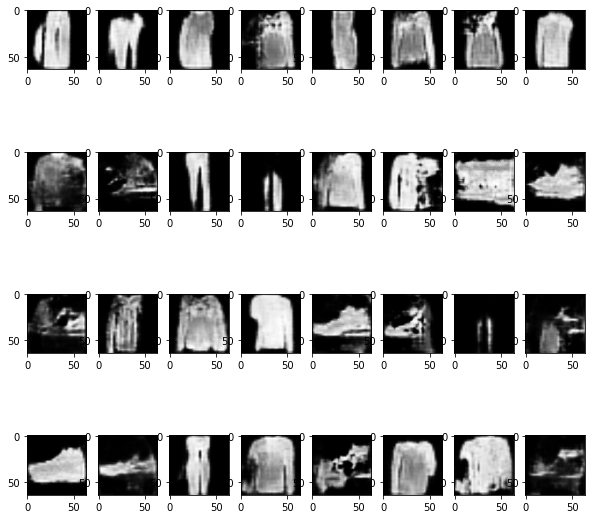

In [ ]:
plt.figure(figsize = (10, 10))
imgs = gen(noize)
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(make_grid(imgs[i], normalize = True).permute(1,2,0))